## Random Forest to Predict Credit Default 
* It is a class imbalance problem 
* We are trying a plain random forest.
* We are also trying GridSearh with CrossValidation
* Comparing the results 

Ref:
https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [1]:
import numpy as np 
import pandas as pd
from pprint import pprint


In [2]:
def plot_confusion_matrix(cm):
    import matplotlib.pyplot as plt
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
    classNames = ['No Default','Default']
    plt.title('Versicolor or Not Versicolor Confusion Matrix - Test Data')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
    plt.show()

In [3]:
data = pd.read_csv('credit-card-default.csv')

In [4]:
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,defaulted
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [5]:
print(data.shape)
print(data.defaulted.value_counts())

(30000, 25)
0    23364
1     6636
Name: defaulted, dtype: int64


 **Data us unbalanced here **

In [6]:
y = data['defaulted']
X = data.drop(['defaulted',],axis=1)

### Encoding Categorical Features

In [7]:
from sklearn import preprocessing


for i in range(0,X.shape[1]):
    if X.dtypes[i]=='object':
        le = preprocessing.LabelEncoder()
        X[X.columns[i]] = le.fit_transform(X[X.columns[i]])

### Train Test Split

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

Accuracy of DecisionTreeClassifier  on test is: 0.7285333333333334


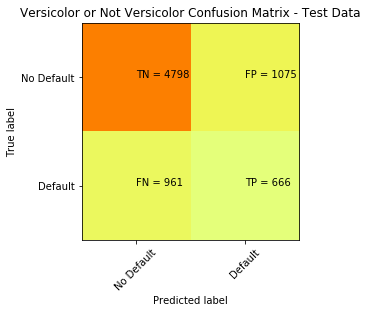

In [11]:
tree_model = DecisionTreeClassifier()
tree_model.fit(X_train, y_train)

tree_pred = tree_model.predict(X_test)

print('Accuracy of DecisionTreeClassifier  on test is:',accuracy_score(y_test,tree_pred))


cm = confusion_matrix(y_test,tree_pred)

plot_confusion_matrix(cm)

Accuracy of Random forest on test is: 0.8054666666666667


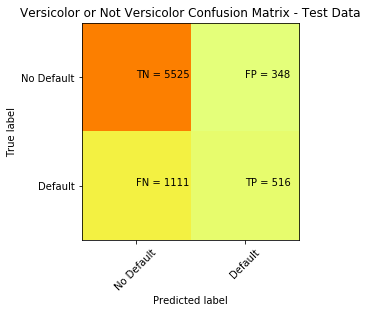

In [12]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train,y_train)

rf_pred = rf_model.predict(X_test)

print('Accuracy of Random forest on test is:',accuracy_score(y_test,rf_pred))

cm = confusion_matrix(y_test,rf_pred)

plot_confusion_matrix(cm)

In [13]:
pprint(rf_model)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


## Random Hyperparameter Grid

In [15]:
from sklearn.model_selection import GridSearchCV
# Number of trees in random forest
n_estimators = [2000]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [20,40]
# max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [ 2, 4]
# Method of selecting samples for training each tree
# bootstrap = [True, False]
# Create the  grid search
param_grid  = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf
#                'bootstrap': bootstrap
              }
pprint(param_grid)

{'max_depth': [20, 40],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [2000]}


Fitting 2 folds for each of 24 candidates, totalling 48 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done  48 out of  48 | elapsed:  8.6min finished


Accuracy of Random forest on test is: 0.8196


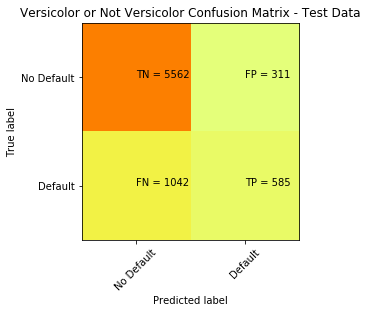

In [16]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
grid_search  = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 2, 
                               verbose=2, n_jobs = -1)

grid_search.fit(X_train,y_train)

# Fit the random search model
rf_pred = grid_search.predict(X_test)
print('Accuracy of Random forest on test is:',accuracy_score(y_test,rf_pred))

cm = confusion_matrix(y_test,rf_pred)

plot_confusion_matrix(cm)

In [18]:
grid_search.best_params_

{'max_depth': 20,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'n_estimators': 2000}

# Comparing Results

You can see here :

1. DecisionTreeModel is producing the accuray of model .79 on test data
2. Plain RandomForest is producing the accuray of model .80 on test data
3. When we have tuned the RandomForest Parameters now model is giving accuacy around .82

We can further improve the accuracy by tuning the tree some more 

Accuracy of Random forest on test is: 0.8204


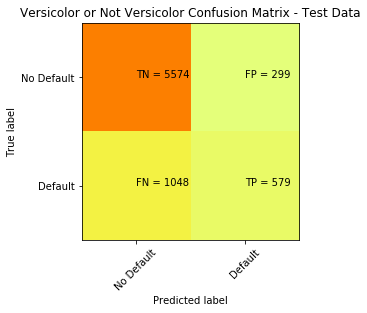

In [20]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
# rf = RandomForestClassifier(n_estimators=5000,
#                             max_depth=[15,25], 
#                             max_features='auto', 
#                             min_samples_leaf=[4,6],
#                             min_samples_split=[3, 5,7])

rf = RandomForestClassifier(n_estimators=5000,
                            max_depth=15, 
                            max_features='auto', 
                            min_samples_leaf=6,
                            min_samples_split=7)

rf.fit(X_train,y_train)

# Fit the random search model
rf_pred = rf.predict(X_test)
print('Accuracy of Random forest on test is:',accuracy_score(y_test,rf_pred))

cm = confusion_matrix(y_test,rf_pred)

plot_confusion_matrix(cm)

Accuracy of Random forest on test is: 0.82


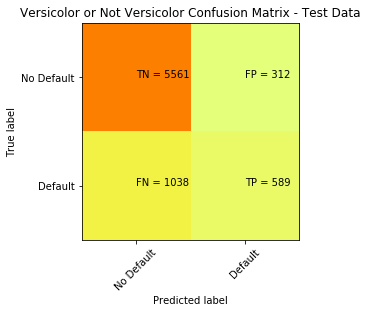

In [21]:
rf = RandomForestClassifier(n_estimators=5000,
                            max_depth=20, 
                            max_features='auto', 
                            min_samples_leaf=4,
                            min_samples_split=5)
rf.fit(X_train,y_train)

# Fit the random search model
rf_pred = rf.predict(X_test)
print('Accuracy of Random forest on test is:',accuracy_score(y_test,rf_pred))

cm = confusion_matrix(y_test,rf_pred)

plot_confusion_matrix(cm)

Accuracy of Random forest on test is: 0.8201333333333334


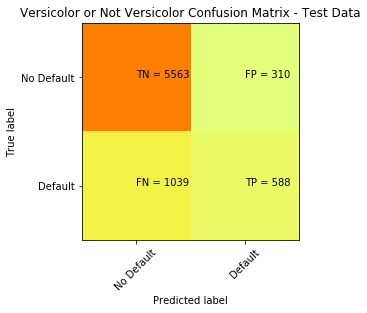

In [25]:
data = pd.read_csv('credit-card-default.csv')

y = data['defaulted']
X = data.drop(['defaulted',],axis=1)

X = pd.get_dummies(X,drop_first=True)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

rf = RandomForestClassifier(n_estimators=5000,
                            max_depth=20, 
                            max_features='auto', 
                            min_samples_leaf=4,
                            min_samples_split=5)
rf.fit(X_train,y_train)

# Fit the random search model
rf_pred = rf.predict(X_test)
print('Accuracy of Random forest on test is:',accuracy_score(y_test,rf_pred))

cm = confusion_matrix(y_test,rf_pred)

plot_confusion_matrix(cm)